# 1. Business Understanding

This is Seattle Airbnb Open Data which can be found on kaggle. The data contains 3 different datasets which provide information like the listing availability and its price, listing's description, listing's location, host's information, listing's review and so on. By providing the hosts useful market information, Airbnb can attract more hosts to its platform and increase the chances of a booking to be made and as a result, earn more service fees. This project aims to make observations from the datasets to draw conclusion that will benefit the hosts.

These are the questions we try to answer:
1. Which month has the least available listings in Seattle which has the least competition in the market?
2. How does number of available listings relate with price? Which month has the highest average price?
3. Do superhosts have better review scores? Could hosts use the review scores to keep track their progress?

# 2. Data Understanding

### Access

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

### Check how big the dataset is, the types and have a first glance on the dataset

In [2]:
df_calendar = pd.read_csv('./data/calendar.csv')
df_listings = pd.read_csv('./data/listings.csv')
df_reviews = pd.read_csv('./data/reviews.csv')

df_calendar.shape, df_listings.shape, df_reviews.shape

((1393570, 4), (3818, 92), (84849, 6))

In [3]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [4]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

## Q1. Which month has the least available listings in Seattle?

### Access
#### Check if there is any missing value in the date and availabilty

In [6]:
df_calendar.isna().mean()

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

#### Check how many data is available for eac listing

In [7]:
df_calendar.groupby('listing_id').count() #count the number of data for each listing in the calendar dataframe

,date,available,price
listing_id,,,
3335,365,365,309
4291,365,365,365
5682,365,365,309
6606,365,365,365
7369,365,365,53
...,...,...,...
10332096,365,365,365
10334184,365,365,361
10339144,365,365,0


In [8]:
df_calendar.groupby('listing_id').count()['date'].mean() #check how many dates are available for each listing

365.0

## 3. Data Preparation

### Clean

#### Convert the date to datetime type to extract information about the month of the date

In [9]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format="%Y/%m/%d") #convert date object to datatime type

In [10]:
df_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
dtype: object

#### Re-access the date now to see if all listings are within the same time frame

In [11]:
df_calendar.groupby('listing_id').date.min()

listing_id
3335       2016-01-04
4291       2016-01-04
5682       2016-01-04
6606       2016-01-04
7369       2016-01-04
              ...    
10332096   2016-01-04
10334184   2016-01-04
10339144   2016-01-04
10339145   2016-01-04
10340165   2016-01-04
Name: date, Length: 3818, dtype: datetime64[ns]

In [12]:
df_calendar.groupby('listing_id').date.min().dt.date.duplicated(keep=False).mean() #check if all listing has the same start date

1.0

In [13]:
df_calendar.groupby('listing_id').date.max()

listing_id
3335       2017-01-02
4291       2017-01-02
5682       2017-01-02
6606       2017-01-02
7369       2017-01-02
              ...    
10332096   2017-01-02
10334184   2017-01-02
10339144   2017-01-02
10339145   2017-01-02
10340165   2017-01-02
Name: date, Length: 3818, dtype: datetime64[ns]

In [14]:
df_calendar.groupby('listing_id').date.max().dt.date.duplicated(keep=False).mean() #check if all listing has the same end date

1.0

#### Split the date into year, month and date columns for easier data accessing

In [15]:
# Split the date into year, month, date and add extra columns for each of them
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day

In [16]:
df_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
year                   int64
month                  int64
day                    int64
dtype: object

## 4. Modelling

### Analyze

#### Choose only the available listing and group them by month and see how many listings are available in each month

In [17]:
# Choose only the available listings
df_available_listing = df_calendar[df_calendar.available=='t'].copy()
df_available_listing_counts = df_available_listing.groupby('month').count()
df_available_listing_counts

,listing_id,date,available,price,year,day
month,,,,,,
1,64937,64937,64937,64937,64937,64937
2,73321,73321,73321,73321,73321,73321
3,83938,83938,83938,83938,83938,83938
4,76037,76037,76037,76037,76037,76037
5,79971,79971,79971,79971,79971,79971
6,77244,77244,77244,77244,77244,77244
7,74222,74222,74222,74222,74222,74222
8,76347,76347,76347,76347,76347,76347
9,77246,77246,77246,77246,77246,77246


## 5. Data Evaluation

### Visualize

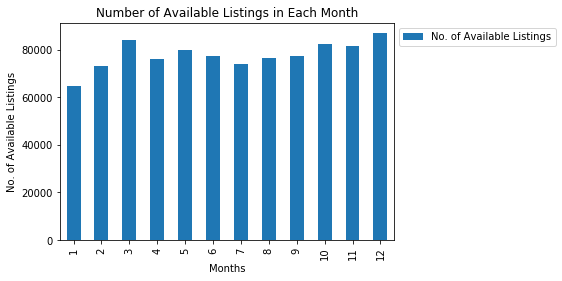

In [18]:
# Group the available listings by month and plot the number of listings in each month in a bar chart
ax = df_available_listing_counts.plot.bar(y='listing_id', label='No. of Available Listings')
ax.set_xlabel('Months');
ax.set_ylabel('No. of Available Listings');
ax.set_title('Number of Available Listings in Each Month');

#Needed so that the legend box will not be cut off during figure export
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1, 1))
text = ax.text(0,0, "", transform=ax.transAxes)

plt.savefig('listings.png', bbox_extra_artists=(lgd, text), bbox_inches='tight')

## Q2. How does number of available listings relate with price? Which month has the highest average price?

## 2. Data Understanding

### Access

In [19]:
df_available_listing['price'].isna().mean() #check if each available listing has a price.

0.0

## 3. Data Preparation

### Clean

#### Price is an object, not an integer when we check the data types before. Now it's time to convert the price to integer type

In [20]:
#elminate dollar sign, and commas from the price and set it to integer
df_available_listing.loc[:, 'price'] = df_available_listing['price'].replace('[\$\,]|\.\d*', '', regex=True).astype(int)
df_available_listing

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,t,85,2016,1,4
1,241032,2016-01-05,t,85,2016,1,5
9,241032,2016-01-13,t,85,2016,1,13
10,241032,2016-01-14,t,85,2016,1,14
14,241032,2016-01-18,t,85,2016,1,18
...,...,...,...,...,...,...,...
1393207,10208623,2016-01-06,t,87,2016,1,6
1393208,10208623,2016-01-07,t,87,2016,1,7
1393211,10208623,2016-01-10,t,87,2016,1,10
1393212,10208623,2016-01-11,t,87,2016,1,11


## 4. Modelling

### Analyze

#### Calculate the average price for all listings in each month. Processing of data in the dataframe and calculation is sum up in a function

In [21]:
def cal_months_avg_price(df):
    """
    This function is used to calculate the average price for all available listings in each month.
    
    Parameters:
    df - Pandas DataFrame which contains all available listings with respective price and month as integer
    
    return:
    df_result - A Pandas Dataframe which contains the listing_id and its average price in all months
    months_list - A list of months detected in the df
    
    """
    # Create list of listing_ids and months in df
    listings_list = list(set(df['listing_id']))
    months_list = list(set(df['month']))
    
    # intialization of variables
    avg_price_list = np.zeros((len(listings_list),12))
    row_count = 0;
    col_count = 0;
    
    # for each listing_id, select a certain month and compute its mean
    for month in months_list:
        for listing in listings_list:
            sel_listing = df['listing_id'] == listing
            sel_month = df['month'] == month

            if (df[sel_listing & sel_month].empty != False):
                avg_price_list[row_count, col_count] = np.NaN
            else:
                avg_price_list[row_count, col_count] = df[sel_listing & sel_month].price.mean()
            
            row_count += 1
            
        col_count += 1
        row_count = 0
        
    # Output results in a data frame
    d = {'listing_id': listings_list, 'Jan': avg_price_list[:, 0],
        'Feb': avg_price_list[:, 1],
        'March': avg_price_list[:, 2],
        'April': avg_price_list[:, 3],
        'May': avg_price_list[:, 4],
        'June': avg_price_list[:, 5],
        'July': avg_price_list[:, 6],
        'Aug': avg_price_list[:, 7],
        'Sep': avg_price_list[:, 8],
        'Oct': avg_price_list[:, 9],
        'Nov': avg_price_list[:, 10],
        'Dec': avg_price_list[:, 11]}
    
    df_result = pd.DataFrame(data=d).round(2)
    df_result = df_result.set_index('listing_id')


    return df_result, months_list

#### After calculation, check the results by checking the head of the results dataframe

In [22]:
# Compute average price for all available listings in each month
df_month_avg_price, months_list = cal_months_avg_price(df_available_listing)
df_month_avg_price.head()

,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec
listing_id,,,,,,,,,,,,
8953857,129.00,NaN,NaN,138.33,137.39,137.0,136.1,155.16,135.0,134.81,134.33,135.45
2727938,91.25,85.00,87.56,99.47,110.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598023,99.00,99.00,99.00,99.00,99.00,99.0,99.0,99.00,99.0,99.00,99.00,99.00
794633,114.58,100.17,107.81,136.20,191.74,198.0,198.0,198.00,198.0,198.00,198.00,198.00
958475,85.00,85.00,85.00,85.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.00


#### Check the size of the results dataframe and the computed months in the function to make sure the result is plausible

In [23]:
df_month_avg_price.shape, months_list

((3723, 12), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

## 5. Data Evaluation

### Visualize

#### Combine the Q2 results with Q1 for a better understanding of the relationship between price and number of available listing

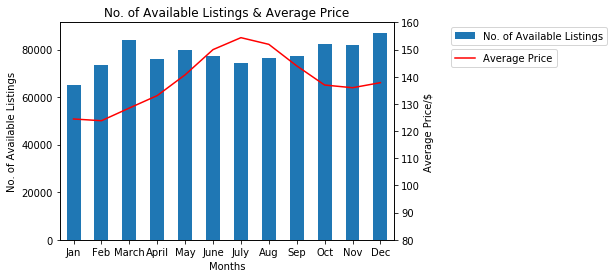

In [24]:
#Plot 2 results in the same axes
ax = df_available_listing_counts.plot.bar(y='listing_id', style='b', legend=True)
df_month_avg_price.mean(axis=0, skipna=True).plot(ax=ax, style='r', legend=True, secondary_y=True)

#customization of the plots
lgd = ax.legend(['No. of Available Listings'], bbox_to_anchor=(1.65, 1))
ax.right_ax.legend(['Average Price'], bbox_to_anchor=(1.5, 0.9))
ax.set_xlabel('Months')
ax.set_ylabel('No. of Available Listings')
ax.right_ax.set_ylabel('Average Price/$')
ax.right_ax.set_yticks([80, 90, 100, 110, 120, 130, 140, 150, 160])

#Needed so that the legend box will not be cut off during figure export
handles, labels = ax.get_legend_handles_labels()
text = ax.text(0,0, "", transform=ax.transAxes)
ax.set_title('No. of Available Listings & Average Price');

#Export the image for medium blog post
plt.savefig('listing_vs_price.png', bbox_extra_artists=(lgd, text), bbox_inches='tight')

## Q3. Do superhosts have better review scores? Could hosts use the review scores to keep track their progress?

## 2. Data Understanding

### Access

#### Check the shape and columns in the dataset to find the relevant review column names

In [25]:
df_listings.shape

(3818, 92)

In [26]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

#### Check if there is any NaN in the superhost and review scores columns

In [27]:
df_listings['host_is_superhost'].isna().mean()

0.0005238344683080147

In [28]:
df_listings['review_scores_rating'].isna().mean()

0.16946045049764275

In [29]:
df_listings['review_scores_cleanliness'].isna().mean()

0.17103195390256679

In [30]:
df_listings['review_scores_checkin'].isna().mean()

0.17234154007333682

In [31]:
df_listings['review_scores_communication'].isna().mean()

0.17050811943425878

In [32]:
df_listings['review_scores_location'].isna().mean()

0.1715557883708748

In [33]:
df_listings['review_scores_value'].isna().mean()

0.17181770560502882

## 3. Data Preparation

### Clean

In [34]:
# Drop NaN in the 'host_is_superhost' and review columns
target_col_list =['host_is_superhost','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                  'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']

df_listings.dropna(subset=target_col_list, inplace=True)
df_listings.shape

(3158, 92)

In [35]:
#Check the number of non-superhost
df_listings[df_listings['host_is_superhost']=='f']['host_is_superhost'].value_counts()

f    2407
Name: host_is_superhost, dtype: int64

In [36]:
#Check the number of superhost
len(df_listings[df_listings['host_is_superhost']=='t'])

751

## 4. Modelling

### Analyze

#### Calculate the mean of each of the review scores for superhost and non superhost

In [37]:
def cal_avg_value(df, col_list, is_superhost):
    """
    This function is used to calculate the average value of the target columns for superhost or non-superhost.
    
    Parameters:
    df - Pandas DataFrame without NaN in the target column.
    col_list - A list of column names, whose average has to be calculated.
    
    return - A Pandas Series of average value of the target column
    
    """
    
    if (is_superhost != True):
        df_selected = df[df['host_is_superhost']=='f']
    else:
        df_selected = df[df['host_is_superhost']=='t']
        
    return df_selected.loc[:,col_list].mean()

In [38]:
superhost_avg_rating = cal_avg_value(df_listings, target_col_list, True)
non_superhost_avg_rating = cal_avg_value(df_listings, target_col_list, False)

#### Check the results

In [39]:
superhost_avg_rating, non_superhost_avg_rating

(review_scores_rating           97.395473
 review_scores_accuracy          9.905459
 review_scores_cleanliness       9.885486
 review_scores_checkin           9.964048
 review_scores_communication     9.974700
 review_scores_location          9.750999
 review_scores_value             9.749667
 dtype: float64,
 review_scores_rating           93.647694
 review_scores_accuracy          9.552971
 review_scores_cleanliness       9.453261
 review_scores_checkin           9.731201
 review_scores_communication     9.759867
 review_scores_location          9.564603
 review_scores_value             9.359369
 dtype: float64)

In [40]:
#Convert the pandas Series to list to better modify the values in it
superhost_avg_rating = list(superhost_avg_rating)
non_superhost_avg_rating = list(non_superhost_avg_rating)
superhost_avg_rating, non_superhost_avg_rating

([97.39547270306258,
  9.905459387483356,
  9.88548601864181,
  9.964047936085219,
  9.974700399467377,
  9.750998668442078,
  9.749667110519308],
 [93.64769422517656,
  9.552970502700457,
  9.453261321146655,
  9.731200664727877,
  9.759867054424594,
  9.5646032405484,
  9.359368508516827])

#### review_scores_rating is too high to be visualize together with the rest of the review scores. Divide it by 10 for better comparision visually.

In [41]:
# For a better visualization of all the review scores, the review_scores_rating is divided by 10
superhost_avg_rating[0] = superhost_avg_rating[0]/10
non_superhost_avg_rating[0] = non_superhost_avg_rating[0]/10
superhost_avg_rating, non_superhost_avg_rating

([9.739547270306257,
  9.905459387483356,
  9.88548601864181,
  9.964047936085219,
  9.974700399467377,
  9.750998668442078,
  9.749667110519308],
 [9.364769422517657,
  9.552970502700457,
  9.453261321146655,
  9.731200664727877,
  9.759867054424594,
  9.5646032405484,
  9.359368508516827])

## 5. Data Evaluation

## Visualize

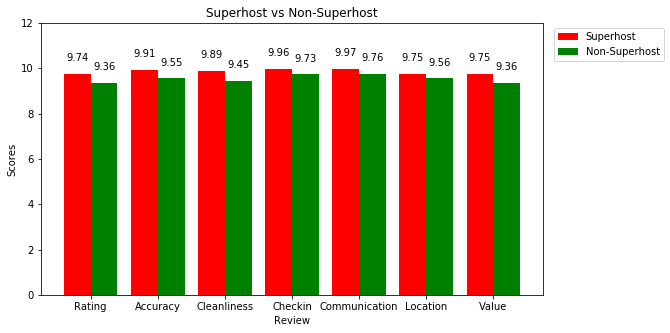

In [42]:
# Preparing configuration variables
x = np.arange(len(target_col_list)-1)
x_labels = ['Rating','Accuracy','Cleanliness','Checkin','Communication','Location','Value']
bar_width = 0.4

# Plot the 2 bar plots in the same axes
plt.figure(figsize=(9,5))
ax = plt.subplot(111)
bar1 = ax.bar(x, superhost_avg_rating, width=bar_width, color='r', align='center', label='Superhost')
bar2 = ax.bar(x+bar_width, non_superhost_avg_rating, width=bar_width, color='g', align='center', label='Non-Superhost')

# Configuration of the plot
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(x_labels)
ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
ax.set_xlabel('Review')
ax.set_ylabel('Scores')
ax.set_title('Superhost vs Non-Superhost')

# Function to display value at the top of each bar
def label_bar(bars):
    """
    Attach a text label above each bar displaying its height
    
    Parameters:
    bars - Bar container 
    """
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height, '%.2f' % float(height), ha='center', va='bottom')

label_bar(bar1)
label_bar(bar2)

# Needed so that the legend box will not be cut off during figure export
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1.25, 1))
text = ax.text(0,0, "", transform=ax.transAxes)
plt.savefig('Superhost_vs_Non-Superhost.png', bbox_extra_artists=(lgd, text), bbox_inches='tight')

plt.show()